In [1]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

KeyboardInterrupt: 

In [ ]:
def generate_imperfect_grid_adjacency_matrix(num_nodes, skip_prob=0.15, extra_edges=0.15):
    if num_nodes <= 1:
        raise ValueError("Number of nodes must be greater than 1")

    grid_size = int(np.ceil(np.sqrt(num_nodes)))
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

    for i in range(num_nodes):
        if i % grid_size != grid_size - 1 and i + 1 < num_nodes:  # Connect to right neighbor
            if random.random() > skip_prob:
                adjacency_matrix[i][i + 1] = 1
                adjacency_matrix[i + 1][i] = 1
        if i + grid_size < num_nodes:  # Connect to bottom neighbor
            if random.random() > skip_prob:
                adjacency_matrix[i][i + grid_size] = 1
                adjacency_matrix[i + grid_size][i] = 1

    num_extra_edges = int(extra_edges * num_nodes)
    edges_added = 0
    while edges_added < num_extra_edges:
        node1 = random.randint(0, num_nodes - 1)
        node2 = random.randint(0, num_nodes - 1)
        if node1 != node2 and adjacency_matrix[node1][node2] == 0:
            adjacency_matrix[node1][node2] = 1
            adjacency_matrix[node2][node1] = 1
            edges_added += 1

    return adjacency_matrix

def generate_complex_seasonal_pattern(length, amplitude_range, period_range, num_periods_range, noise_level=0.1):
    t = np.arange(length)
    seasonal_pattern = np.zeros(length)
    num_periods = np.random.randint(*num_periods_range)
    period_length = length // num_periods

    for _ in range(num_periods):
        frequency = np.random.uniform(0.5, 2.0)
        amplitude = np.random.uniform(*amplitude_range)
        phase = np.random.uniform(0, 2 * np.pi)
        start = np.random.randint(0, length - period_length)
        end = start + period_length
        seasonal_pattern[start:end] += amplitude * np.sin(frequency * 2 * np.pi * t[start:end] / period_length + phase)
            
    seasonal_pattern += noise_level * np.random.normal(size=length)
    return 1 + seasonal_pattern  # Ensure the factor is always positive

def generate_pickup_time_series(num_nodes, length, mean, std_dev, exogenous_pct, skip_prob=0.15, extra_edges=0.15, amplitude_range=(0.5, 1.5), period_range=(10, 50), num_periods_range=(3, 10)):
    # Generate the adjacency matrix
    adj_matrix = generate_imperfect_grid_adjacency_matrix(num_nodes, skip_prob, extra_edges)

    # Initialize the pickup matrix
    pickups = np.zeros((length, num_nodes), dtype=float)
    
    # Generate the complex seasonal patterns for each node with different parameters
    seasonal_patterns = np.array([generate_complex_seasonal_pattern(length, amplitude_range, period_range, num_periods_range) for _ in range(num_nodes)])
    
    # Generate initial pickups with complex seasonal patterns
    for t in range(length):
        for i in range(num_nodes):
            pickups[t, i] = np.random.normal(mean * seasonal_patterns[i, t], std_dev)
            if pickups[t, i] < 0:
                pickups[t, i] = 0

    # Generate exogenous influence
    G = nx.from_numpy_array(adj_matrix)
    distance_matrix = dict(nx.all_pairs_shortest_path_length(G))
    
    for t in range(1, length):
        new_pickups = np.zeros(num_nodes)
        for i in range(num_nodes):
            exogenous_sum = 0
            endogenous_pickups = pickups[t, i]
            for j in range(num_nodes):
                if i != j:
                    distance = distance_matrix[i][j]
                    weight = 1 / (1 + distance)  # Discount based on distance
                    exogenous_sum += pickups[t-1, j] * weight
            
            exogenous_pickups = exogenous_sum / (num_nodes - 1)
            new_pickups[i] = (1 - exogenous_pct) * endogenous_pickups + exogenous_pct * exogenous_pickups
            
            if new_pickups[i] < 0:
                new_pickups[i] = 0
        
        pickups[t] = new_pickups
    
    return pickups, adj_matrix

def visualize_graph(adj_matrix):
    G = nx.from_numpy_array(adj_matrix)
    
    pos = {}
    grid_size = int(np.ceil(np.sqrt(len(adj_matrix))))
    for i in range(len(adj_matrix)):
        pos[i] = (i % grid_size, grid_size - (i // grid_size))
    
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
    plt.title("Imperfect Grid-Like City Graph")
    plt.show()

def visualize_pickup_series(pickup_series):
    length, num_nodes = pickup_series.shape
    time_steps = np.arange(length)
    
    plt.figure(figsize=(12, 8))
    for i in range(num_nodes):
        plt.plot(time_steps, pickup_series[:, i], label=f'Node {i}')
    
    plt.xlabel('Time Step')
    plt.ylabel('Pickups')
    plt.title('Taxi Pickup Time Series')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.05))
    plt.grid(True)
    plt.show()

def visualize_node_influence(pickup_series):
    correlation_matrix = np.corrcoef(pickup_series.T)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=True, yticklabels=True)
    plt.title('Correlation Heatmap of Taxi Pickup Time Series')
    plt.xlabel('Node')
    plt.ylabel('Node')
    plt.show()

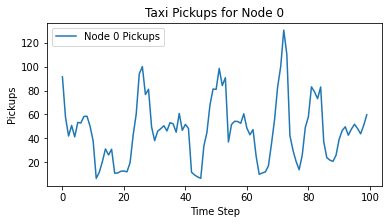

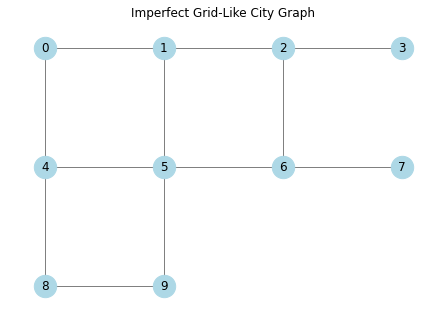

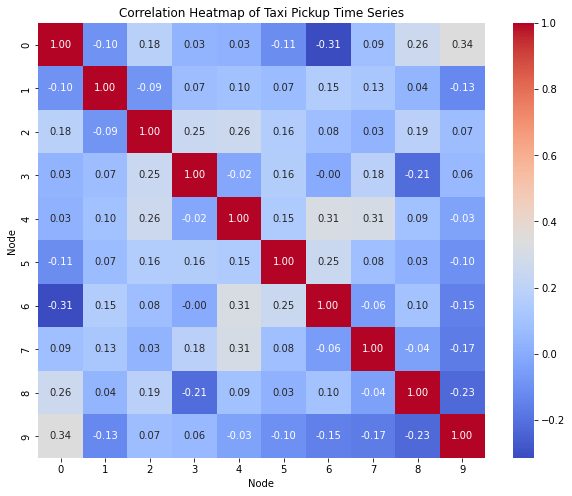

In [ ]:

num_nodes = 10 
length = 100
mean = 100
std_dev = 10
exogenous_pct = 0.8

pickup_series, adj_matrix = generate_pickup_time_series(num_nodes, length, mean, std_dev, exogenous_pct)

# Plot the data for Node 0
plt.figure(figsize=(6, 3))
plt.plot(pickup_series[:, 0], label='Node 0 Pickups')
plt.xlabel('Time Step')
plt.ylabel('Pickups')
plt.title('Taxi Pickups for Node 0')
plt.legend()
plt.show()


visualize_graph(adj_matrix)      
visualize_node_influence(pickup_series)

In [ ]:
train_size = length // 2
train_data = pickup_series[:train_size]
test_data = pickup_series[train_size:]

# Scale the data
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)



Node 0, Epoch [10/100], Loss: 0.2712
Node 0, Epoch [20/100], Loss: 0.1372
Node 0, Epoch [30/100], Loss: 0.0789
Node 0, Epoch [40/100], Loss: 0.0855
Early stopping at epoch 41 for node 0
Node 1, Epoch [10/100], Loss: 0.4559
Node 1, Epoch [20/100], Loss: 0.1774
Node 1, Epoch [30/100], Loss: 0.1768
Node 1, Epoch [40/100], Loss: 0.0987
Node 1, Epoch [50/100], Loss: 0.0457
Early stopping at epoch 59 for node 1
Node 2, Epoch [10/100], Loss: 0.2894
Node 2, Epoch [20/100], Loss: 0.1679
Node 2, Epoch [30/100], Loss: 0.4628
Node 2, Epoch [40/100], Loss: 0.2523
Early stopping at epoch 49 for node 2
Node 3, Epoch [10/100], Loss: 0.2091
Node 3, Epoch [20/100], Loss: 0.1458
Node 3, Epoch [30/100], Loss: 0.1538
Node 3, Epoch [40/100], Loss: 0.1053
Node 3, Epoch [50/100], Loss: 0.1027
Early stopping at epoch 53 for node 3
Node 4, Epoch [10/100], Loss: 0.3461
Node 4, Epoch [20/100], Loss: 0.1742
Node 4, Epoch [30/100], Loss: 0.1952
Early stopping at epoch 34 for node 4
Node 5, Epoch [10/100], Loss: 0.7

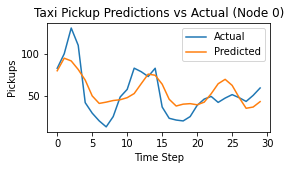

In [ ]:
train_data = torch.tensor(train_data, dtype=torch.float32)
test_data = torch.tensor(test_data, dtype=torch.float32)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)  # Dropout for regularization

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(self.dropout(out[:, -1, :]))
        return out

input_size = 1  # Single node input size
hidden_size = 100
output_size = 1  # Single node output size
num_layers = 2
num_epochs = 100
learning_rate = 0.001

seq_length = 20

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append((seq, target))
    return sequences

# Training and testing on each node individually
predictions = []
targets = []

for node in range(train_data.shape[1]):
    node_train_data = train_data[:, node].unsqueeze(1)
    node_test_data = test_data[:, node].unsqueeze(1)

    model = LSTM(input_size, hidden_size, output_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_sequences = create_sequences(node_train_data, seq_length)
    test_sequences = create_sequences(node_test_data, seq_length)

    model.train()
    best_loss = float('inf')
    patience = 10
    counter = 0

    for epoch in range(num_epochs):
        total_loss = 0
        for seq, target in train_sequences:
            seq = seq.unsqueeze(0)
            target = target.unsqueeze(0)

            output = model(seq)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_sequences)
        if avg_loss < best_loss:
            best_loss = avg_loss
            counter = 0
            torch.save(model.state_dict(), f'best_model_node_{node}.pth')
        else:
            counter += 1
        if counter > patience:
            print(f'Early stopping at epoch {epoch + 1} for node {node}')
            break

        if (epoch + 1) % 10 == 0:
            print(f'Node {node}, Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

    model.load_state_dict(torch.load(f'best_model_node_{node}.pth'))

    model.eval()
    node_predictions = []
    node_targets = []
    with torch.no_grad():
        for seq, target in test_sequences:
            seq = seq.unsqueeze(0)
            target = target.unsqueeze(0)
            output = model(seq)
            node_predictions.append(output.squeeze().cpu().numpy())
            node_targets.append(target.squeeze().cpu().numpy())

    predictions.append(node_predictions)
    targets.append(node_targets)

predictions = np.array(predictions)
targets = np.array(targets)

# Inverse transform the scaled data (assuming scaler was fitted on train_data)
predictions = scaler.inverse_transform(predictions.T)
targets = scaler.inverse_transform(targets.T)

# Calculate the mean squared error
mse = mean_squared_error(targets.flatten(), predictions.flatten())
print(f'Mean Squared Error: {mse:.4f}')

# Plot the predictions vs actual values for the first node
plt.figure(figsize=(4, 2))
plt.plot(targets[:, 0], label='Actual')
plt.plot(predictions[:, 0], label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Pickups')
plt.title('Taxi Pickup Predictions vs Actual (Node 0)')
plt.legend()
plt.show()

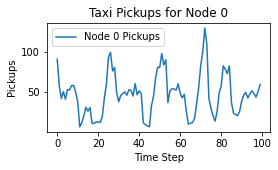

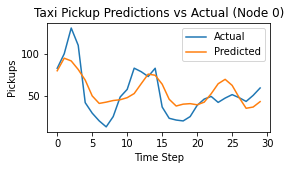

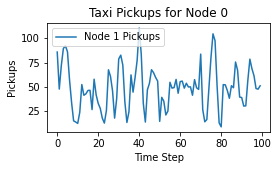

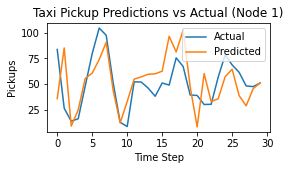

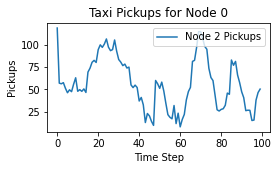

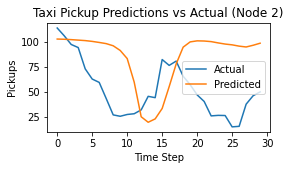

In [ ]:

for x in range(3):
    plt.figure(figsize=(4, 2))
    plt.plot(pickup_series[:, x], label=f'Node {x} Pickups')
    plt.xlabel('Time Step')
    plt.ylabel('Pickups')
    plt.title('Taxi Pickups for Node 0')
    plt.legend()
    plt.show()



    plt.figure(figsize=(4, 2))
    plt.plot(targets[:, x], label='Actual')
    plt.plot(predictions[:, x], label='Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Pickups')
    plt.title(f'Taxi Pickup Predictions vs Actual (Node {x})')
    plt.legend()
    plt.show()

In [ ]:
train_data = torch.tensor(train_data, dtype=torch.float32)
test_data = torch.tensor(test_data, dtype=torch.float32)

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)  # Dropout for regularization

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(self.dropout(out[:, -1, :]))
        return out

input_size = 1  # Single node input size
hidden_size = 100
output_size = 1  # Single node output size
num_layers = 2
num_epochs = 100
learning_rate = 0.001

seq_length = 20

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append((seq, target))
    return sequences

# Training and testing on each node individually
predictions = []
targets = []

for node in range(train_data.shape[1]):
    node_train_data = train_data[:, node].unsqueeze(1)
    node_test_data = test_data[:, node].unsqueeze(1)

    model = GRU(input_size, hidden_size, output_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_sequences = create_sequences(node_train_data, seq_length)
    test_sequences = create_sequences(node_test_data, seq_length)

    model.train()
    best_loss = float('inf')
    patience = 10
    counter = 0

    for epoch in range(num_epochs):
        total_loss = 0
        for seq, target in train_sequences:
            seq = seq.unsqueeze(0)
            target = target.unsqueeze(0)

            output = model(seq)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_sequences)
        if avg_loss < best_loss:
            best_loss = avg_loss
            counter = 0
            torch.save(model.state_dict(), f'best_model_node_{node}.pth')
        else:
            counter += 1
        if counter > patience:
            print(f'Early stopping at epoch {epoch + 1} for node {node}')
            break

        if (epoch + 1) % 10 == 0:
            print(f'Node {node}, Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

    model.load_state_dict(torch.load(f'best_model_node_{node}.pth'))

    model.eval()
    node_predictions = []
    node_targets = []
    with torch.no_grad():
        for seq, target in test_sequences:
            seq = seq.unsqueeze(0)
            target = target.unsqueeze(0)
            output = model(seq)
            node_predictions.append(output.squeeze().cpu().numpy())
            node_targets.append(target.squeeze().cpu().numpy())

    predictions.append(node_predictions)
    targets.append(node_targets)

predictions = np.array(predictions)
targets = np.array(targets)

# Inverse transform the scaled data (assuming scaler was fitted on train_data)
predictions = scaler.inverse_transform(predictions.T)
targets = scaler.inverse_transform(targets.T)

# Calculate the mean squared error
mse = mean_squared_error(targets.flatten(), predictions.flatten())
print(f'Mean Squared Error: {mse:.4f}')

C:\Users\kragg\AppData\Local\Temp\ipykernel_14772\1460827523.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(train_data, dtype=torch.float32)
C:\Users\kragg\AppData\Local\Temp\ipykernel_14772\1460827523.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = torch.tensor(test_data, dtype=torch.float32)


Node 0, Epoch [10/100], Loss: 0.2657
Node 0, Epoch [20/100], Loss: 0.2396
Node 0, Epoch [30/100], Loss: 0.2186
Early stopping at epoch 39 for node 0
Node 1, Epoch [10/100], Loss: 0.3525
Node 1, Epoch [20/100], Loss: 0.2735
Node 1, Epoch [30/100], Loss: 0.2049
Node 1, Epoch [40/100], Loss: 0.0632
Node 1, Epoch [50/100], Loss: 0.0746
Early stopping at epoch 58 for node 1
Node 2, Epoch [10/100], Loss: 0.3027
Node 2, Epoch [20/100], Loss: 0.1581
Early stopping at epoch 30 for node 2
Node 3, Epoch [10/100], Loss: 0.1435
Node 3, Epoch [20/100], Loss: 0.1203
Node 3, Epoch [30/100], Loss: 0.0882
Node 3, Epoch [40/100], Loss: 0.1139
Early stopping at epoch 41 for node 3
Node 4, Epoch [10/100], Loss: 0.2259
Node 4, Epoch [20/100], Loss: 0.1527
Node 4, Epoch [30/100], Loss: 0.1681
Node 4, Epoch [40/100], Loss: 0.1538
Node 4, Epoch [50/100], Loss: 0.1581
Early stopping at epoch 60 for node 4
Node 5, Epoch [10/100], Loss: 0.7867
Node 5, Epoch [20/100], Loss: 0.2705
Node 5, Epoch [30/100], Loss: 0.1

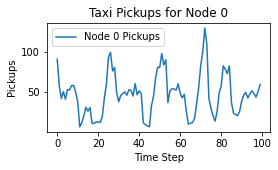

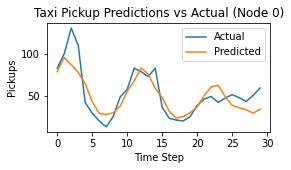

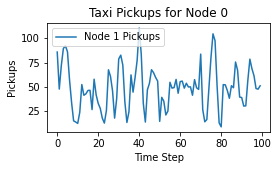

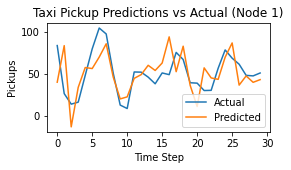

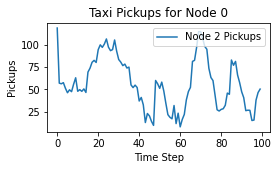

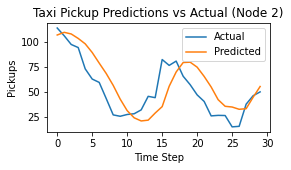

In [ ]:

for x in range(3):
    plt.figure(figsize=(4, 2))
    plt.plot(pickup_series[:, x], label=f'Node {x} Pickups')
    plt.xlabel('Time Step')
    plt.ylabel('Pickups')
    plt.title('Taxi Pickups for Node 0')
    plt.legend()
    plt.show()



    plt.figure(figsize=(4, 2))
    plt.plot(targets[:, x], label='Actual')
    plt.plot(predictions[:, x], label='Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Pickups')
    plt.title(f'Taxi Pickup Predictions vs Actual (Node {x})')
    plt.legend()
    plt.show()